<a href="https://colab.research.google.com/github/maxjinli/DASC6510/blob/main/A2_Q4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.stats import invgamma, norm, stats, gamma, binom, bernoulli, multivariate_normal, wishart, gaussian_kde
import scipy.stats as stats
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from io import StringIO
from numpy.linalg import inv, cholesky
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from scipy.special import expit as logistic_function
import statsmodels.api as sm
from numpy.random import uniform
from scipy.linalg import solve
from scipy.special import expit, logit

In [2]:
with open('/content/drive/MyDrive/DASC 6510/mathstandard.dat', 'r') as f:
    data = f.read()

In [3]:
# Read string data into a pandas DataFrame
dat = pd.read_csv(StringIO(data), delim_whitespace=True)

In [4]:
dat

,county,metstandard,percentms
0,Adams,0,43.8
1,Adams,1,33.3
2,Adams,1,41.7
3,Asotin,0,50.0
4,Asotin,0,69.8
...,...,...,...
369,Grant,0,60.0
370,Spokane,0,84.6
371,Spokane,0,100.0
372,King,1,56.1


**Part (b)**

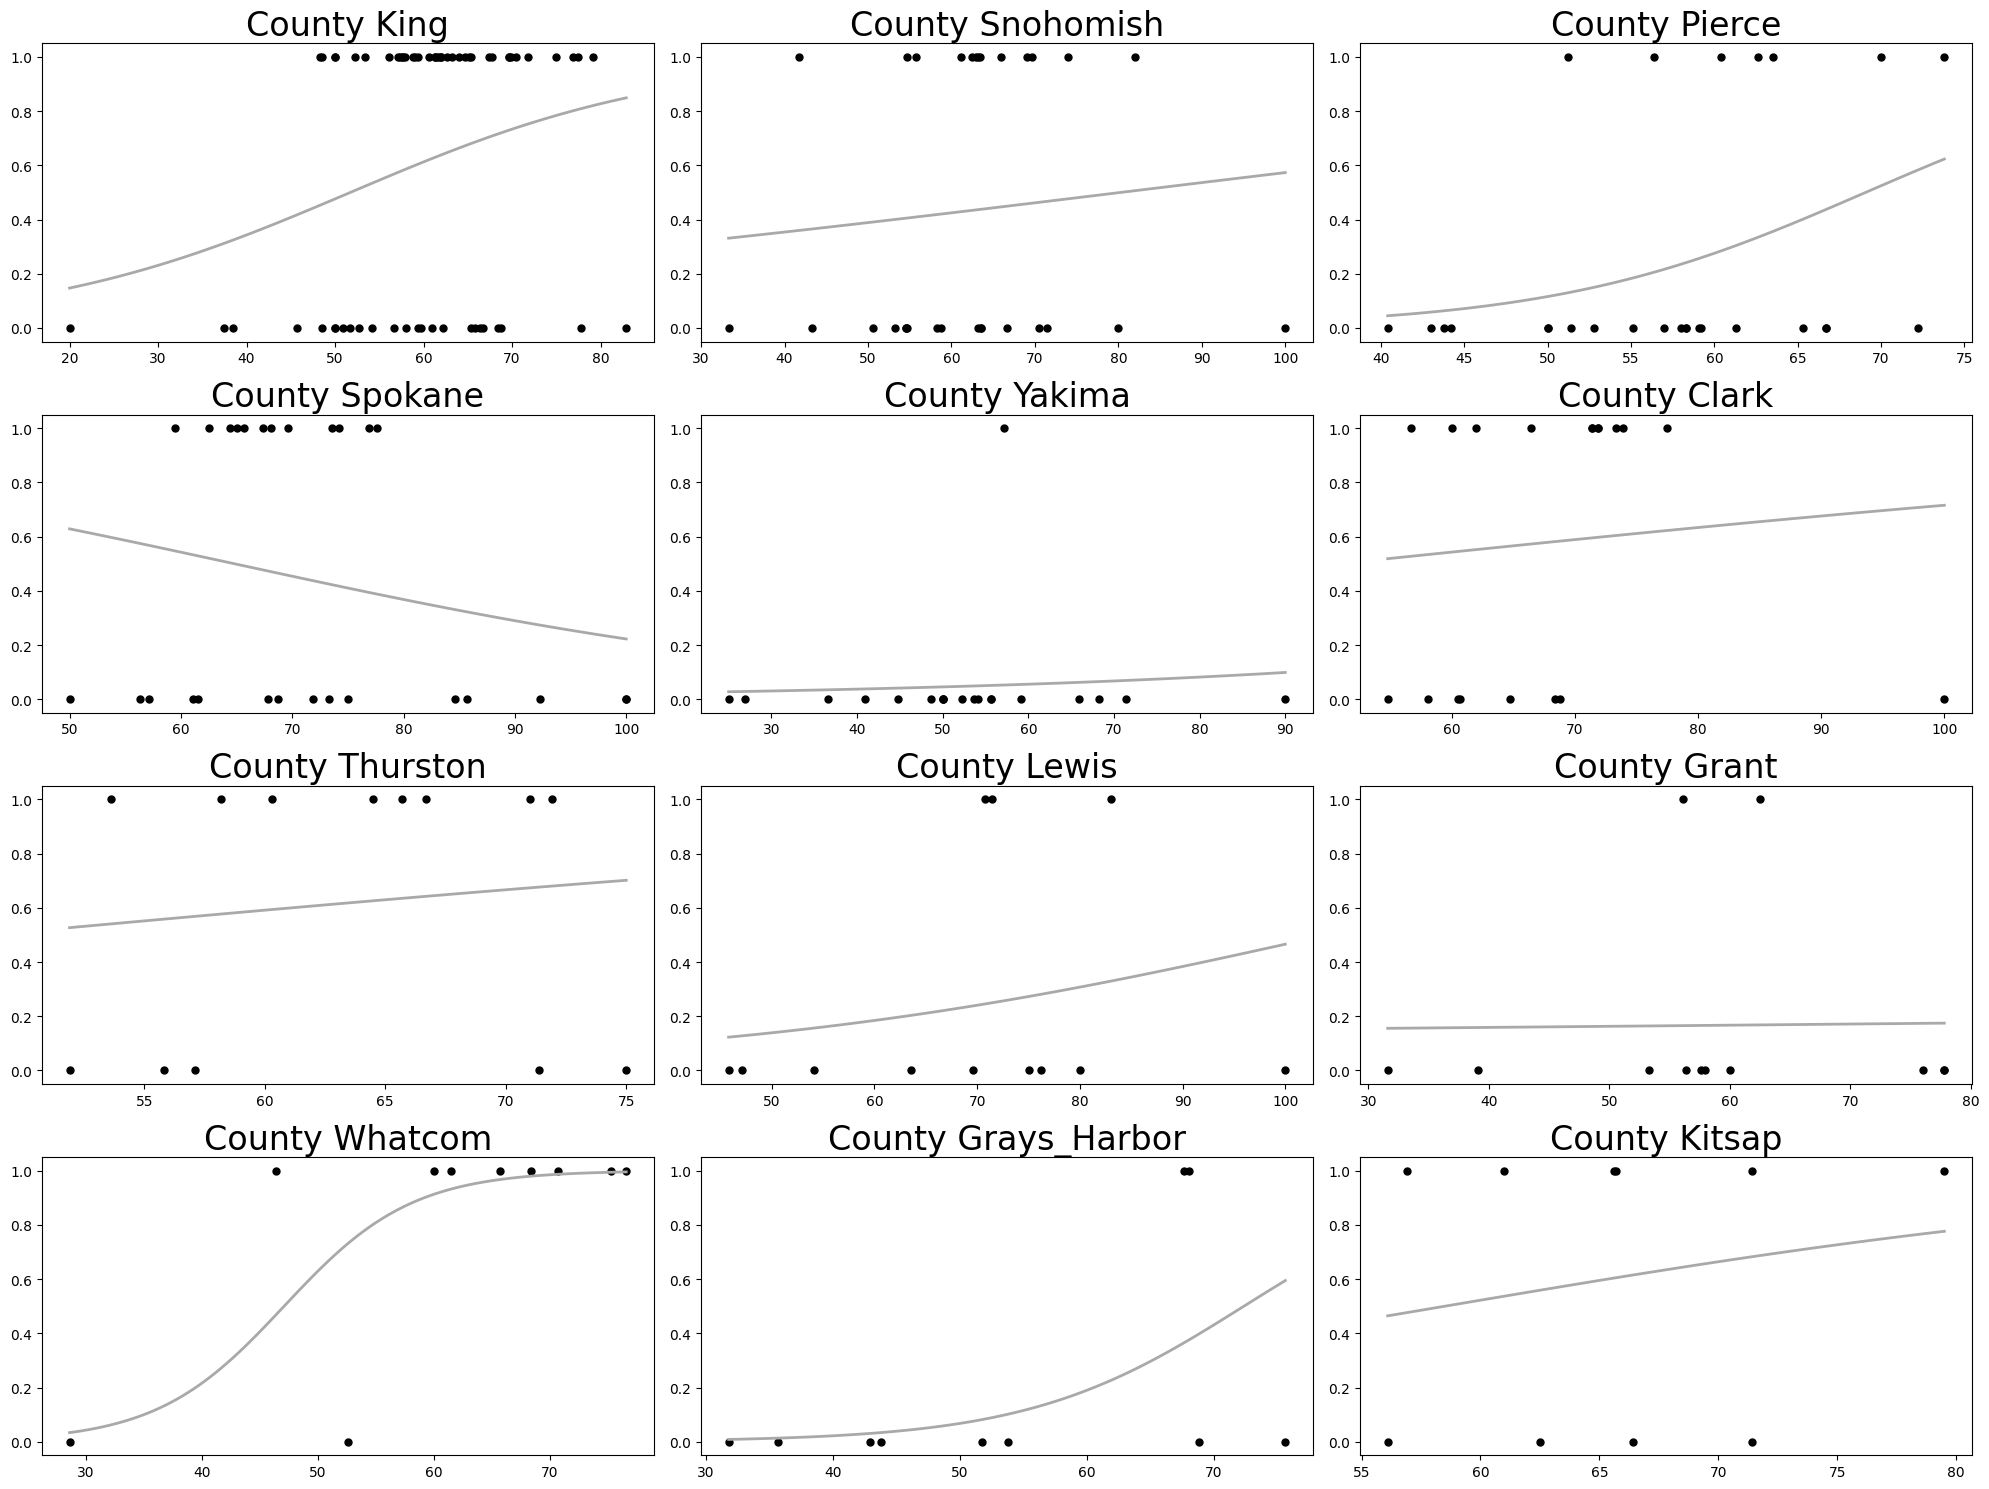

In [5]:
schools_per_county = dat['county'].value_counts()

counties = schools_per_county[schools_per_county >= 10].index

Beta_mle = []
filtered_counties = []

for c in counties:
    dat_c = dat[dat['county'] == c]
    yj = dat_c['metstandard']
    xj = sm.add_constant(dat_c['percentms'])
    try:
        model = sm.Logit(yj, xj).fit(disp=0)
        Beta_mle.append(model.params.values)
        filtered_counties.append(c)
    except np.linalg.LinAlgError:
        continue

Beta_mle = np.array(Beta_mle)
theta_hat = Beta_mle.mean(axis=0)
Sigma_hat = np.cov(Beta_mle.T)

# Plots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
axes = axes.flatten()

for i, c in enumerate(counties):
    ax = axes[i]
    dat_c = dat[dat['county'] == c]
    xj = dat_c['percentms']
    yj = dat_c['metstandard']
    beta = Beta_mle[i]

    x = np.linspace(xj.min(), xj.max(), 100)
    ax.plot(xj, yj, 'o', markersize=5, alpha=1, color="black")
    ax.plot(x, 1 / (1 + np.exp(-(beta[0] + beta[1] * x))), '-', linewidth=2, color="darkgray")
    ax.set_title(c, fontdict={'fontsize': 22, 'fontweight': 'bold'})
    ax.set_title("County " + c, fontsize=24)

plt.tight_layout()
plt.show()

In [6]:
# Obtain the theta estimates
theta_hat

array([-3.46274672,  0.05070387])

In [7]:
# Obtain the sigma estimates
Sigma_hat

array([[ 1.07558215e+01, -1.79360977e-01],
       [-1.79360977e-01,  3.48979959e-03]])

**Part (c)**

In [8]:
def sample_theta(Beta, Sigma, mu0, Lambda0):
    n_group = Beta.shape[1]
    iSigma = inv(Sigma)
    iLambda0 = inv(Lambda0)

    mBeta = Beta.mean(axis=1)
    Lambdam = inv(iLambda0 + n_group * iSigma)
    mum = Lambdam @ (iLambda0 @ mu0[:, None] + n_group * iSigma @ mBeta[:, None])

    return multivariate_normal.rvs(mean=mum.flatten(), cov=Lambdam)

def sample_Sigma(Beta, theta, eta0, S0):
    g = Beta.shape[1]
    Sn = S0 + ((Beta - theta[:, None]) @ (Beta - theta[:, None]).T)
    return inv(wishart.rvs(df=eta0 + g, scale=inv(Sn)))

def logistic_regression_log_prior(beta, theta, Sigma):
    return multivariate_normal.logpdf(beta, mean=theta, cov=Sigma)

def logistic_regression_log_likelihood(beta, y, X):
    eta = X @ beta
    return np.sum(y * eta - np.log(1 + np.exp(eta)))

def sample_Beta(y, X, groups, theta, Sigma, Beta, adj_prop):
    Beta_new = np.empty(Beta.shape)
    Acs = []

    ugroups = np.unique(groups)
    for g in ugroups:
        idx = groups == g
        Xg, yg = X[idx], y[idx]
        betag = Beta[:, g:g+1].flatten()

        # Proposal step
        beta_p = multivariate_normal.rvs(mean=betag, cov=adj_prop * Sigma)

        # Log likelihood ratio
        lhr = (logistic_regression_log_likelihood(beta_p, yg, Xg) -
               logistic_regression_log_likelihood(betag, yg, Xg) +
               logistic_regression_log_prior(beta_p, theta, Sigma) -
               logistic_regression_log_prior(betag, theta, Sigma))

        # Acceptance step
        if np.log(np.random.rand()) < lhr:
            Beta_new[:, g] = beta_p
            Acs.append(1)
        else:
            Beta_new[:, g] = betag
            Acs.append(0)

    return Beta_new, np.mean(Acs)

In [9]:
schools_per_county = dat['county'].value_counts()
twelve_counties = schools_per_county[schools_per_county >= 10].index
filtered_data = dat[dat['county'].isin(twelve_counties)]

y = filtered_data['metstandard'].values
X = np.column_stack((np.ones(len(filtered_data)), filtered_data['percentms'].values))
groups = pd.factorize(filtered_data['county'])[0]

p = 2
n_group = len(np.unique(groups))

# Initial parameters
mu0 = theta_hat
Lambda0 = Sigma_hat
eta0 = 4
S0 = Sigma_hat
adj_prop = 1.2

In [10]:
# MCMC Configuration
n_iter = 10000

# Empty Arrays
theta_samples = np.zeros((n_iter, p))
Sigma_samples = np.zeros((n_iter, p, p))
Beta_samples = np.zeros((n_iter, p, n_group))

# Initial values for theta and Sigma
theta = mu0
Sigma = S0
Beta = np.tile(mu0, (n_group, 1)).T

# loop
for i in range(n_iter):
    theta = sample_theta(Beta, Sigma, mu0, Lambda0)
    Sigma = sample_Sigma(Beta, theta, eta0, S0)
    Beta, _ = sample_Beta(y, X, groups, theta, Sigma, Beta, adj_prop)

    # Store the samples
    theta_samples[i] = theta
    Sigma_samples[i] = Sigma
    Beta_samples[i] = Beta



In [11]:
theta_samples

array([[-2.66146444,  0.04355213],
       [-3.62313839,  0.05394125],
       [-3.47394304,  0.04885459],
       ...,
       [-2.090509  ,  0.0325432 ],
       [-3.23301204,  0.04326359],
       [-3.21618401,  0.0476451 ]])

In [12]:
 Sigma_samples

array([[[ 1.29526251e+00, -1.63218159e-02],
        [-1.63218159e-02,  2.41254618e-04]],

       [[ 1.63736105e+00, -2.35223248e-02],
        [-2.35223248e-02,  3.90017184e-04]],

       [[ 9.13604768e-01, -1.54694776e-02],
        [-1.54694776e-02,  3.10439184e-04]],

       ...,

       [[ 1.84727238e+00, -1.92921319e-02],
        [-1.92921319e-02,  4.56534739e-04]],

       [[ 2.33259371e+00, -4.75828920e-02],
        [-4.75828920e-02,  1.16952695e-03]],

       [[ 1.85468114e+00, -3.35364615e-02],
        [-3.35364615e-02,  6.91860160e-04]]])

In [13]:
Beta_samples

array([[[-3.46274672, -3.46274672, -2.49742732, ..., -3.01224635,
         -4.39497044, -3.46274672],
        [ 0.05070387,  0.05070387,  0.03311792, ...,  0.04717067,
          0.06756099,  0.05070387]],

       [[-3.97374483, -3.46274672, -2.49742732, ..., -4.31216353,
         -4.39497044, -3.46274672],
        [ 0.06218152,  0.05070387,  0.03311792, ...,  0.07298248,
          0.06756099,  0.05070387]],

       [[-4.20584224, -3.31035628, -2.22344107, ..., -4.60469714,
         -4.39497044, -2.5085473 ],
        [ 0.06470115,  0.05039419,  0.02389605, ...,  0.07397038,
          0.06756099,  0.01896013]],

       ...,

       [[-4.05014104, -1.75675141, -2.47214698, ..., -4.65025708,
         -3.08069683, -3.58181212],
        [ 0.06577689,  0.01429904,  0.01918689, ...,  0.08195902,
          0.06759206,  0.03220603]],

       [[-4.05014104, -1.75675141, -2.85087386, ..., -4.65025708,
         -3.33342839, -3.58181212],
        [ 0.06577689,  0.01429904,  0.03036664, ...,  0.08195

**Part (d)**

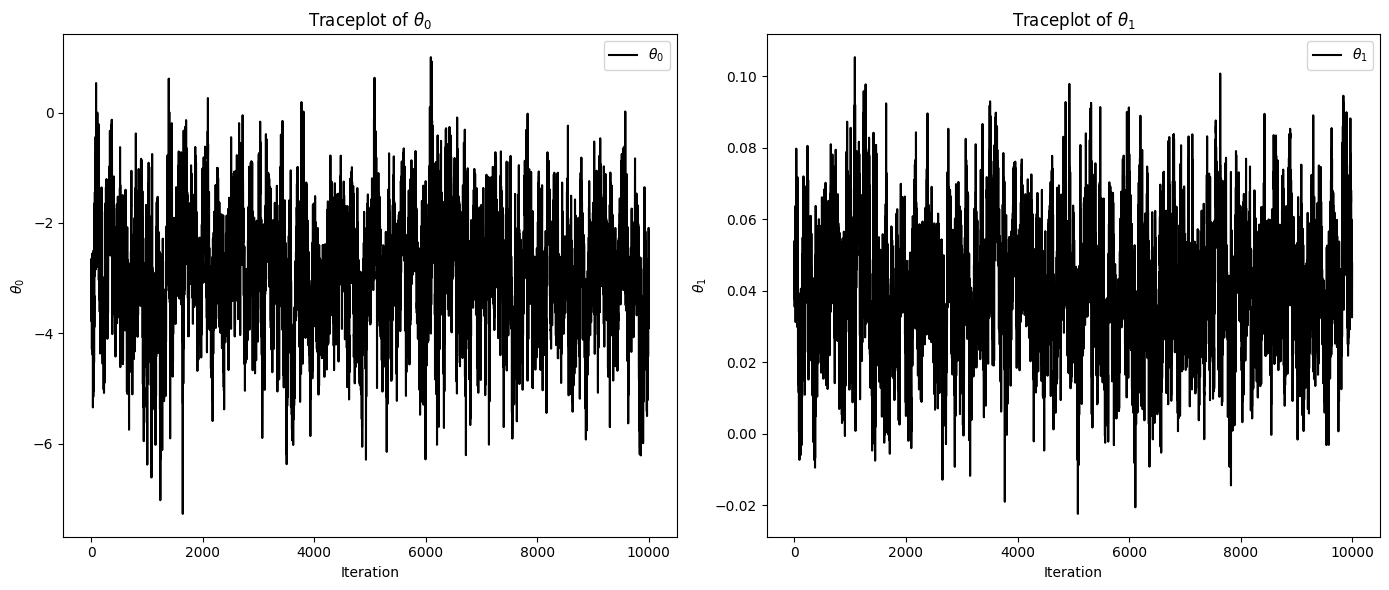

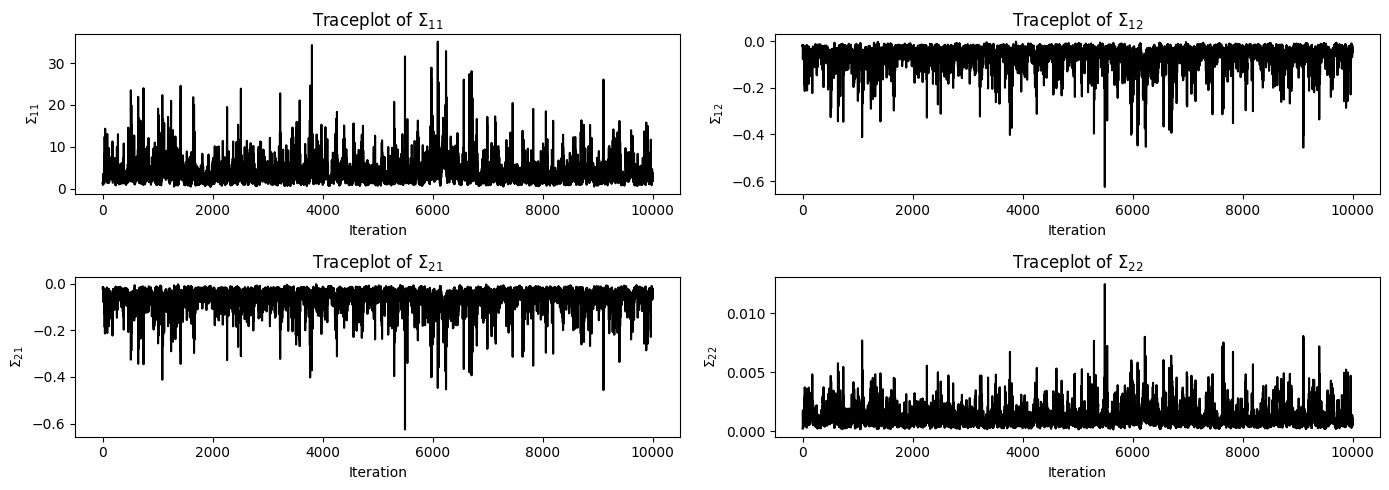

In [14]:
import matplotlib.pyplot as plt

n_iter = len(theta_samples)  # Assuming theta_samples is defined

# Theta samples
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(n_iter), theta_samples[:, 0], label=r'$\theta_0$', color='black')
plt.xlabel('Iteration')
plt.ylabel(r'$\theta_0$')
plt.title(r'Traceplot of $\theta_0$')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(n_iter), theta_samples[:, 1], label=r'$\theta_1$', color='black')
plt.xlabel('Iteration')
plt.ylabel(r'$\theta_1$')
plt.title(r'Traceplot of $\theta_1$')
plt.legend()

plt.tight_layout()
plt.show()

# Sigma samples
fig, axes = plt.subplots(2, 2, figsize=(14, 5))

# Sigma[1, 1] samples
axes[0, 0].plot(range(n_iter), [Sigma_samples[i, 0, 0] for i in range(n_iter)], color='black')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel(r'$\Sigma_{11}$')
axes[0, 0].set_title(r'Traceplot of $\Sigma_{11}$')

# Sigma[1, 2] samples
axes[0, 1].plot(range(n_iter), [Sigma_samples[i, 0, 1] for i in range(n_iter)], color='black')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel(r'$\Sigma_{12}$')
axes[0, 1].set_title(r'Traceplot of $\Sigma_{12}$')

# Sigma[2, 1] samples
axes[1, 0].plot(range(n_iter), [Sigma_samples[i, 1, 0] for i in range(n_iter)], color='black')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel(r'$\Sigma_{21}$')
axes[1, 0].set_title(r'Traceplot of $\Sigma_{21}$')

# Sigma[2, 2] samples
axes[1, 1].plot(range(n_iter), [Sigma_samples[i, 1, 1] for i in range(n_iter)], color='black')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel(r'$\Sigma_{22}$')
axes[1, 1].set_title(r'Traceplot of $\Sigma_{22}$')

plt.tight_layout()
plt.show()


Part (**e**)

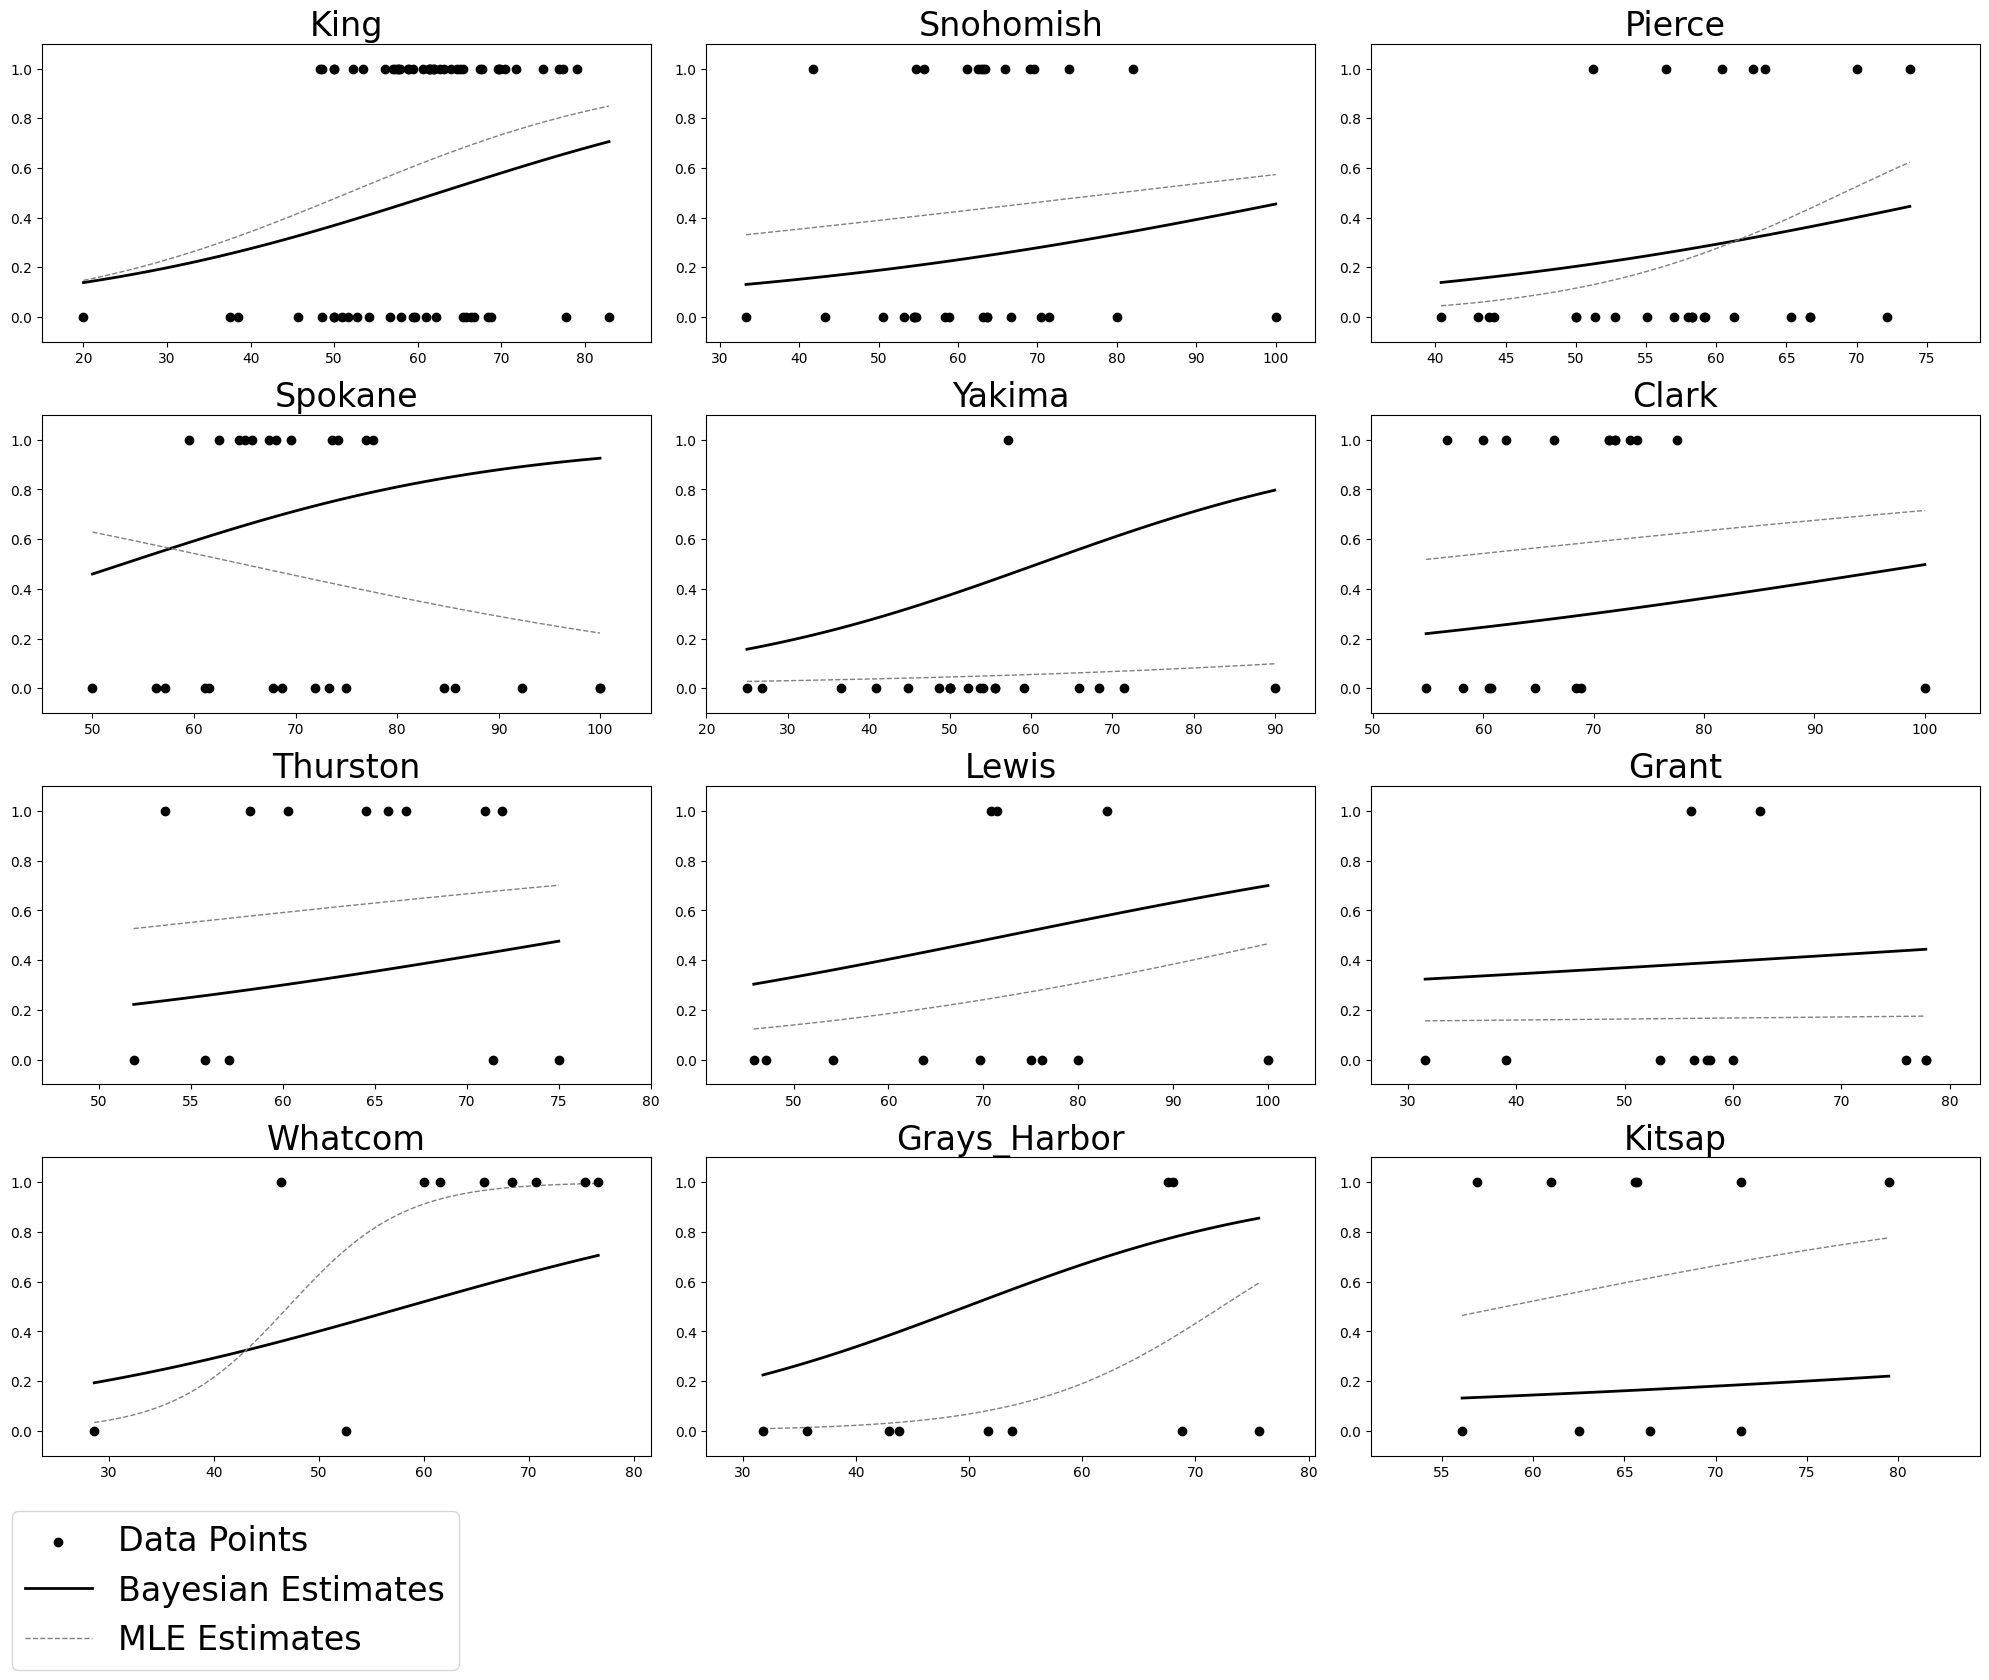

In [15]:
Beta_bayes = Beta_samples.mean(axis=0)

def plot_logistic_regression(ax, x, beta, label, style, color, lw):
    x_values = np.linspace(min(x), max(x), 100)
    y_values = expit(beta[0] + beta[1] * x_values)
    ax.plot(x_values, y_values, label=label, linestyle=style, color=color, linewidth=lw)

# Adjust the subplot arrangement if needed
fig, axes = plt.subplots(nrows=int(np.ceil(len(filtered_counties)/3)), ncols=3, figsize=(20, 15), squeeze=False)
axes = axes.flatten()

legend_labels = []

for i, county in enumerate(filtered_counties):
    county_data = dat[dat['county'] == county]
    xj = county_data['percentms'].values
    yj = county_data['metstandard'].values
    ax = axes[i]

    ax.scatter(xj, yj, color='black', zorder=5)
    plot_logistic_regression(ax, xj, Beta_bayes[:, i], 'Bayesian Estimates', '-', 'black', 2)  # Black and slightly thicker line
    plot_logistic_regression(ax, xj, Beta_mle[i], 'MLE Estimates', '--', 'gray', 1)  # Gray line

    ax.set_title(county, fontsize=24)  # Increased title font size
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(min(xj)-5, max(xj)+5)

# Adjust layout and add a legend
plt.tight_layout()
fig.legend(['Data Points', 'Bayesian Estimates', 'MLE Estimates'], loc='upper left', bbox_to_anchor=(0, 0), fontsize=24)
plt.show()



**Part (f)**

In [17]:
theta_prior = multivariate_normal.rvs(mean=theta_hat, cov=Sigma_hat, size=10000)

In [18]:
Sigma_prior_samples = np.array([wishart.rvs(df=4, scale=Sigma_hat) for _ in range(10000)])
Sigma_prior = np.linalg.inv(Sigma_prior_samples)

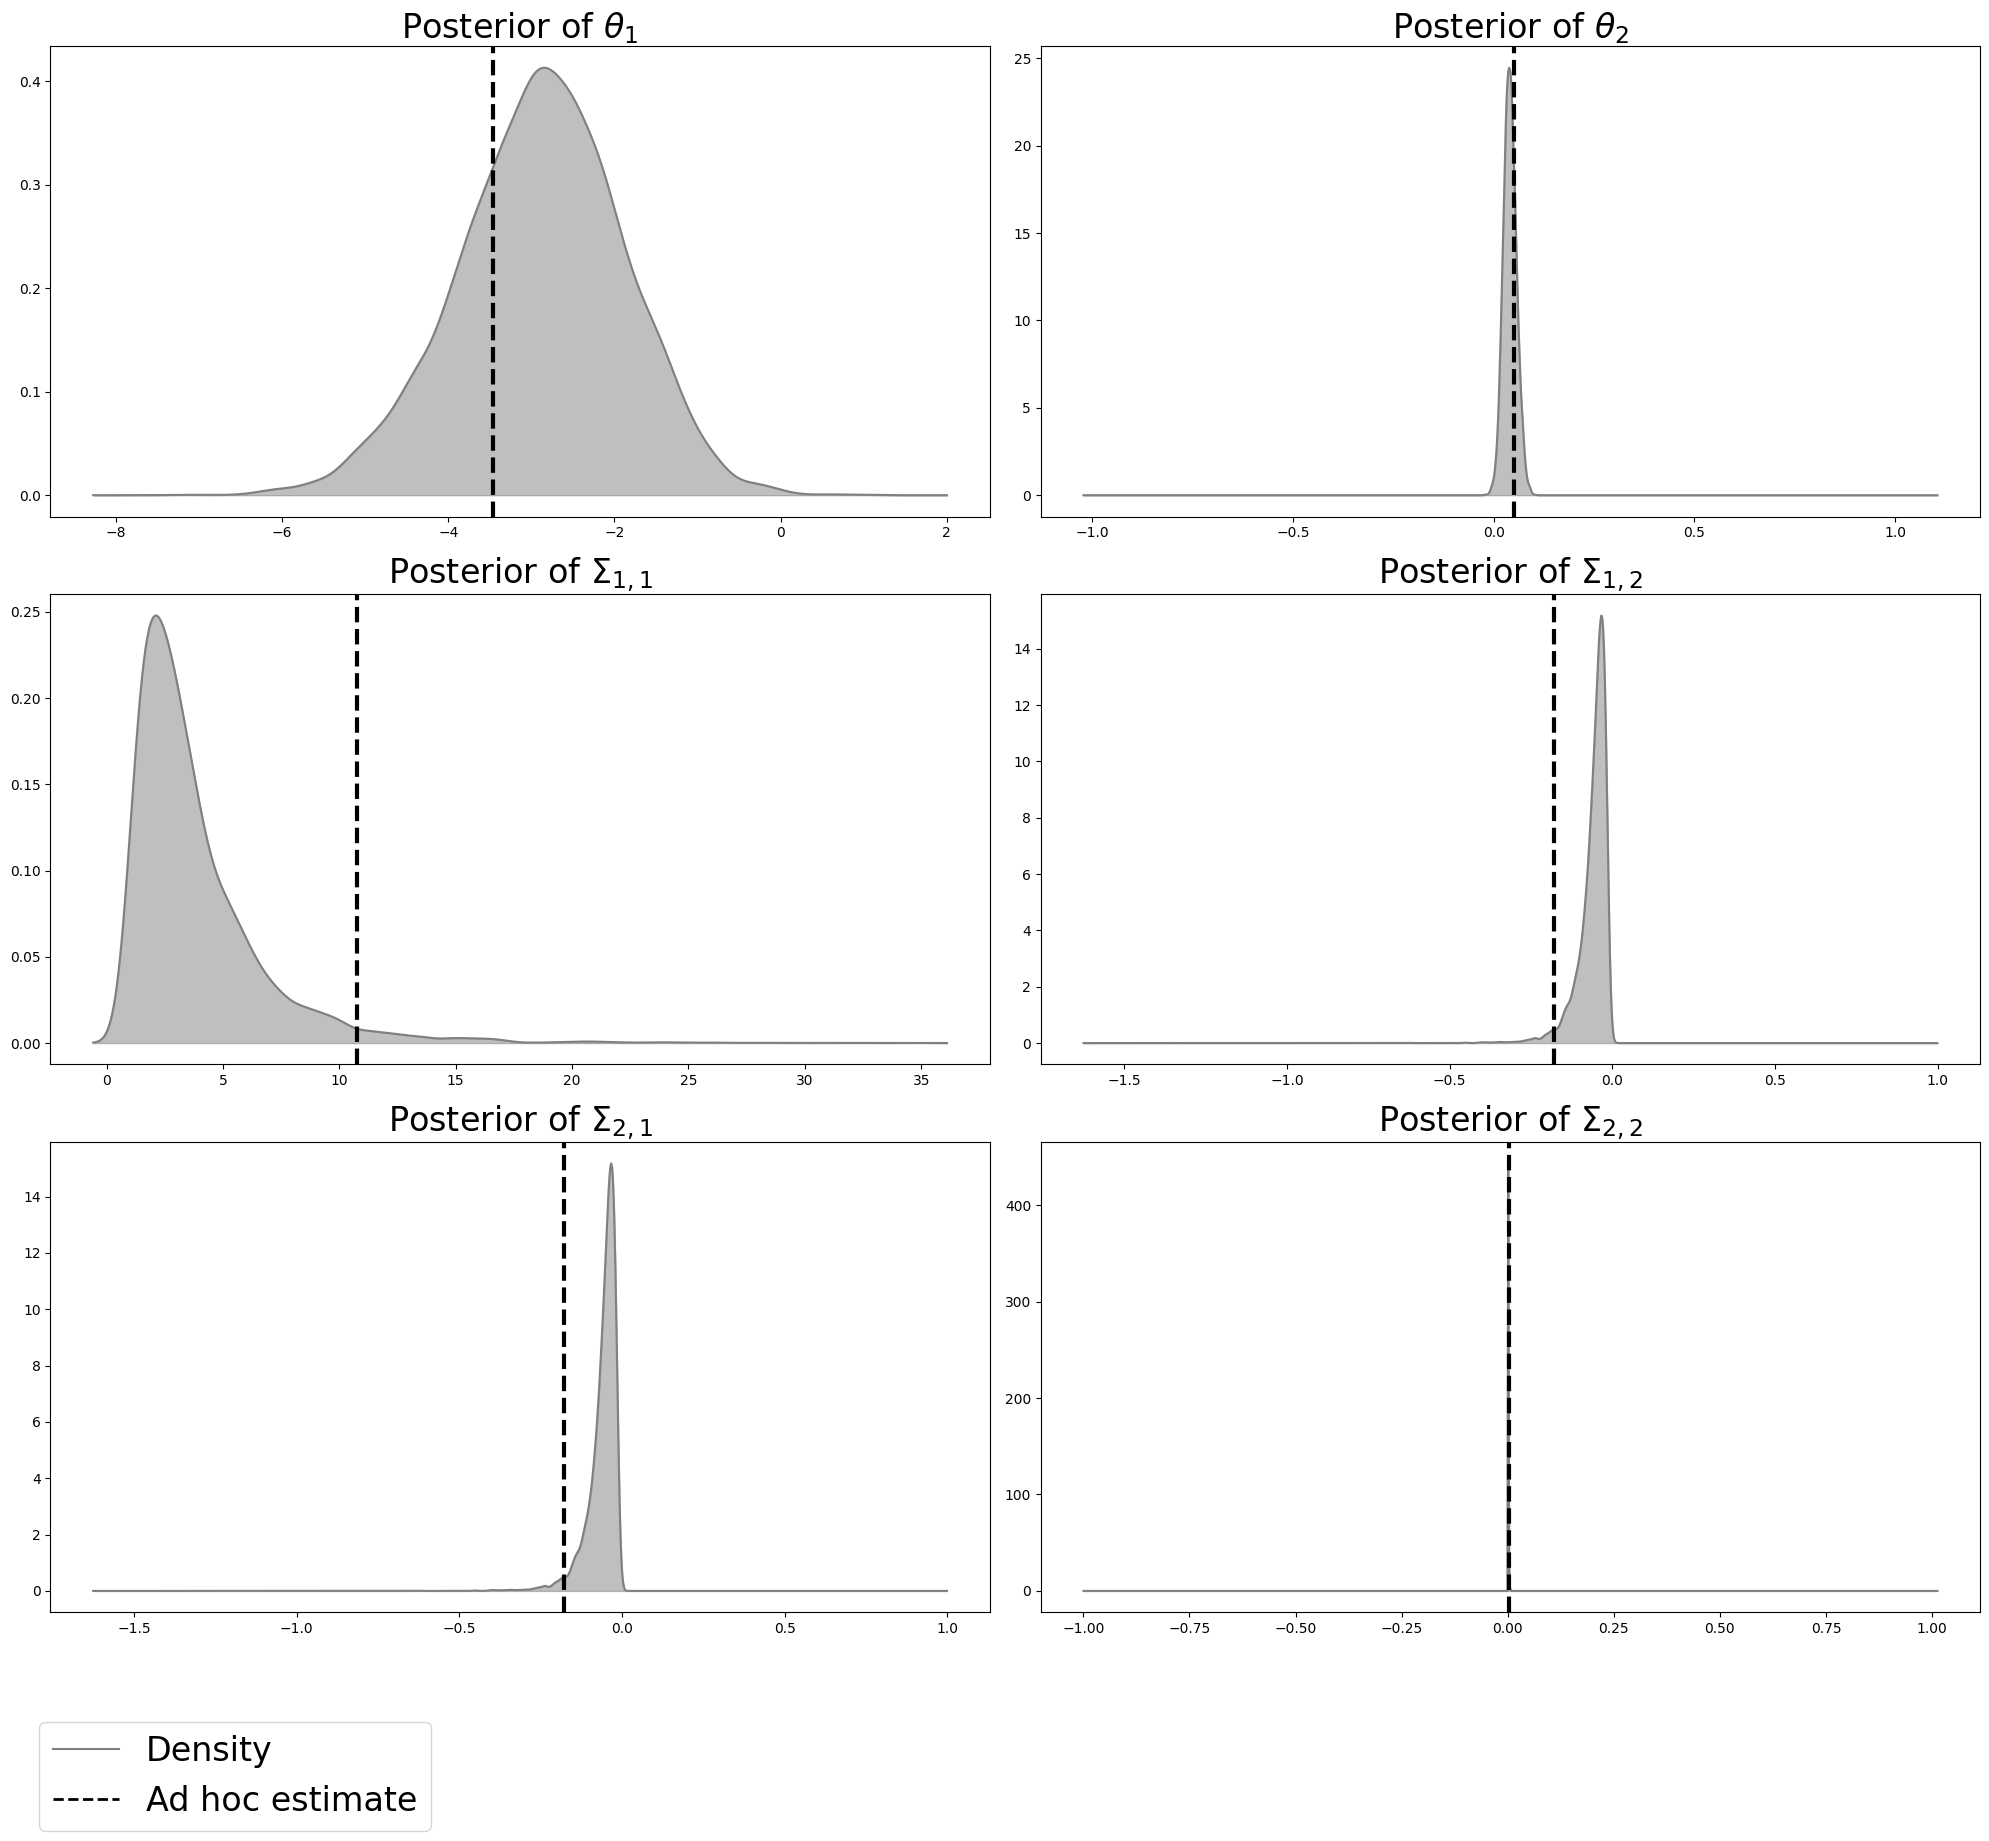

In [45]:
def plot_density(ax, data, title, ad_hoc_estimate=None, color='gray', ad_hoc_color='black', title_fontsize=24, ad_hoc_linewidth=3):
    kde = gaussian_kde(data)
    x_grid = np.linspace(min(data) - 1, max(data) + 1, 1000)
    ax.plot(x_grid, kde(x_grid), color=color)
    ax.fill_between(x_grid, kde(x_grid), color=color, alpha=0.5)
    if ad_hoc_estimate is not None:
        ax.axvline(ad_hoc_estimate, color=ad_hoc_color, linestyle='--', linewidth=ad_hoc_linewidth)
    ax.set_title(title, fontsize=title_fontsize)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 18))

for i in range(2):
    plot_density(axes[0, i], theta_samples[:, i], f'Posterior of $\\theta_{{{i+1}}}$', theta_hat[i])

indices = [(0, 0), (0, 1), (1, 0), (1, 1)]
for i, index in enumerate(indices):
    row = i // 2 + 1
    col = i % 2
    plot_density(axes[row, col], Sigma_samples[:, index[0], index[1]].flatten(), f'Posterior of $\\Sigma_{{{index[0]+1},{index[1]+1}}}$', Sigma_hat[index])


density_line = plt.Line2D([], [], color='gray', label='Density')
ad_hoc_line = plt.Line2D([], [], color='black', linestyle='--', linewidth=2, label='Ad hoc estimate')

fig.legend(handles=[density_line, ad_hoc_line], loc='upper center', bbox_to_anchor=(0.12, 0), fontsize=24)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

